# Transformers

In [274]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn


In [275]:
SEED=1337

In [276]:
#we'll define a set of seeds and make it reproducible
def set_seeds(seed=1337):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        eval("setattr(torch.backends.cudnn, 'deterministic', True)")
        eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)   
set_seeds(SEED)

In [277]:
#set device
def set_device():
  if torch.backends.mps.is_available():
    device=torch.device("mps")
  elif torch.cuda.is_available():
    device=torch.device("cuda")
  else:
    device=torch.device("cpu")
  #for now we're just going to be on cpu because torch 2.0.0 has problems with mps backend
  return torch.device('cpu')
  return device
device=set_device()
if (device.type=='cuda'):
  torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
  torch.set_default_tensor_type("torch.FloatTensor")
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cpu


In [278]:
#Load data

df=pd.read_csv(os.path.join('..','Attention','train.csv'))

# df=pd.concat([pd.read_csv('train.csv', header=0), pd.read_csv('test.csv', header=0)])
# df = df.sample(frac=1).reset_index(drop=True) # shuffle
df=df[:3000]
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [279]:
print(len(df))

3000


### Cleaning

In [280]:
import nltk 
# to get rid of common words that dont hold much meaning
from nltk.corpus import stopwords
# to get rid of words that have common suffixes
from nltk.stem import PorterStemmer
import re

nltk.download('stopwords')
STOPWORDS=stopwords.words('english')
print(STOPWORDS[:5])
PORTER=PorterStemmer()

def preprocess(text,stopwords=STOPWORDS):
  #lower
  text=text.lower()
  #remove punctuation
  pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
  text=pattern.sub('',text)

  #remove words in parentheses
  text = re.sub(r"\([^)]*\)", "", text)

  #spacing and filters
  text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
  text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
  text = re.sub(" +", " ", text)  # remove multiple spaces
  text = text.strip()

  return text

text='Great week for the NYSE'
print(preprocess(text))

#apply to all text
preprocessed_df=df.copy()
preprocessed_df['Title']=preprocessed_df['Title'].apply(preprocess)
print(f"{df['Title'].values[0]}\n\n{preprocessed_df['Title'].values[0]}")
#tokenize

['a', 'about', 'above', 'after', 'again']
great week nyse
Wall St. Bears Claw Back Into the Black (Reuters)

wall st bears claw back black


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcwolpert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Split the data

In [281]:
import collections
from sklearn.model_selection import train_test_split

TRAIN_SIZE=0.7
TEST_SIZE=0.15
VAL_SIZE=0.15

def train_val_test_split(X,y,train_size):
  #split the data
  X_train,X_, y_train,y_=train_test_split(X,y,train_size=TRAIN_SIZE,stratify=y)
  X_val,X_test,y_val,y_test=train_test_split(X_,y_,test_size=0.5,stratify=y_)
  return X_train,X_val,X_test,y_train,y_val,y_test

X=preprocessed_df['Title']
y=preprocessed_df['Class Index']
X_train,X_val,X_test,y_train,y_val,y_test=train_val_test_split(X,y,TRAIN_SIZE)

print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train.iloc[0]} → {y_train.iloc[0]}")

X_train: (2100,), y_train: (2100,)
X_val: (450,), y_val: (450,)
X_test: (450,), y_test: (450,)
Sample point: amp profits beat forecasts → 3


### Label Encoding
- We're doing this to encode our text labels into unique indices

In [283]:
import itertools
import json

class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        # Make a brand-new dict with plain Python ints as keys:
        serializable = {int(k): v for k, v in self.class_to_index.items()}

        with open(fp, "w") as out_f:
            json.dump({"class_to_index": serializable}, out_f, indent=4, sort_keys=False)


    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


#Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.save("label_encoder.json")
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index

# Convert labels to tokens
print (f"y_train[0]: {y_train.iloc[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")

#class weights
counts=np.bincount(y_train)
class_weights={i: 1.0/count for i, count in enumerate(counts)}
print(f"counts:{counts}\nweights:{class_weights}")

y_train[0]: 3
y_train[0]: 2
counts:[513 406 493 688]
weights:{0: 0.001949317738791423, 1: 0.0024630541871921183, 2: 0.002028397565922921, 3: 0.0014534883720930232}


### Tokenizer
- Now to convert our text into tokens

In [284]:
import json
from collections import Counter
from more_itertools import take
from transformers import DistilBertTokenizer
from transformers import BertTokenizer

In [285]:
# Load tokenizer and model
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
vocab_size = len(tokenizer)
print (vocab_size)

31090


/Users/marcwolpert/Code/Learning/MadeWithML/madewithml/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [286]:
# Tokenize inputs
encoded_input = tokenizer(list(X_train), return_tensors="pt", padding=True)
X_train_ids = encoded_input["input_ids"]
X_train_masks = encoded_input["attention_mask"]
print (X_train_ids.shape, X_train_masks.shape)
encoded_input = tokenizer(X_val.tolist(), return_tensors="pt", padding=True)
X_val_ids = encoded_input["input_ids"]
X_val_masks = encoded_input["attention_mask"]
print (X_val_ids.shape, X_val_masks.shape)
encoded_input = tokenizer(X_test.tolist(), return_tensors="pt", padding=True)
X_test_ids = encoded_input["input_ids"]
X_test_masks = encoded_input["attention_mask"]
print (X_test_ids.shape, X_test_masks.shape)

torch.Size([2100, 24]) torch.Size([2100, 24])
torch.Size([450, 24]) torch.Size([450, 24])
torch.Size([450, 21]) torch.Size([450, 21])


In [287]:
# Decode
print (f"{X_train_ids[0]}\n{tokenizer.decode(X_train_ids[0])}")

tensor([  102, 10411, 16866, 17016, 17793,   103,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
[CLS] amp profits beat forecasts [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


### Datasets/DataLoaders

In [288]:
from torch.nn.utils.rnn import pad_sequence

class TransformerTextDataset(torch.utils.data.Dataset):
    def __init__(self, ids, masks, targets):
        self.ids     = ids
        self.masks   = masks
        self.targets = targets  # numpy array of ints, e.g. [0,2,1,3,...]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        ids    = torch.tensor(self.ids[index],   dtype=torch.long)
        masks  = torch.tensor(self.masks[index], dtype=torch.long)
        target = torch.tensor(self.targets[index], dtype=torch.long)  
        return ids, masks, target

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset    = self,
            batch_size = batch_size,
            shuffle    = shuffle,
            drop_last  = drop_last,
            pin_memory = False
            # no custom collate needed
        )

In [289]:
# Create datasets
train_dataset = TransformerTextDataset(ids=X_train_ids, masks=X_train_masks, targets=y_train)
val_dataset = TransformerTextDataset(ids=X_val_ids, masks=X_val_masks, targets=y_val)
test_dataset = TransformerTextDataset(ids=X_test_ids, masks=X_test_masks, targets=y_test)
print ("Data splits:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  ids: {train_dataset[0][0]}\n"
    f"  masks: {train_dataset[0][1]}\n"
    f"  targets: {train_dataset[0][2]}")

Data splits:
  Train dataset:<__main__.TransformerTextDataset object at 0x37ef74190>
  Val dataset: <__main__.TransformerTextDataset object at 0x32303c880>
  Test dataset: <__main__.TransformerTextDataset object at 0x37ef742b0>
Sample point:
  ids: tensor([  102, 10411, 16866, 17016, 17793,   103,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
  masks: tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  targets: 2


/Users/marcwolpert/Code/Learning/MadeWithML/madewithml/venv/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [290]:
# Create dataloaders
batch_size = 128


train_dataloader = train_dataset.create_dataloader(
    batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(
    batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(
    batch_size=batch_size)

batch = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  ids: {batch[0].size()}\n"
    f"  masks: {batch[1].size()}\n"
    f"  targets: {batch[2].size()}")

Sample batch:
  ids: torch.Size([128, 24])
  masks: torch.Size([128, 24])
  targets: torch.Size([128])


### Trainer

In [291]:
import torch.nn.functional as F


In [292]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

## Transformers 
- First we're going to learn about the unique components of the Transformers architecture, then we'll implement one for our text classification task.

### Scaled Dot Product Attention
- This is the original attention mechanism introduced in the paper "Attention is All You Need".
- This type of attention involves projecting the encoded input sequences onto three matrices:
- **Query (Q)**
- **Key (K)**
- **Value (V)**
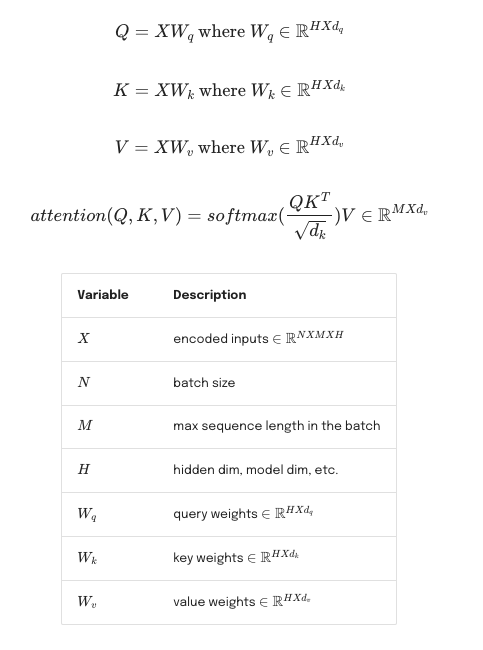

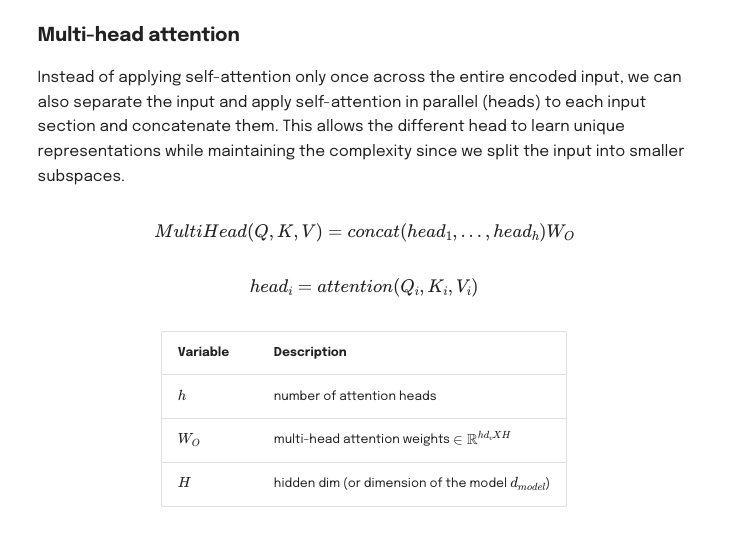
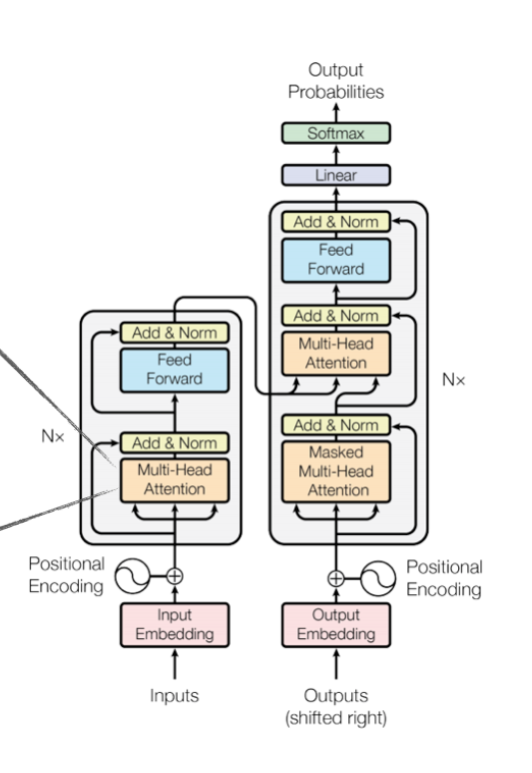

In [293]:
from transformers import BertModel

In [294]:
# Arguments
lr = 1e-4
num_epochs = 10
patience = 10

In [295]:
# transformer = BertModel.from_pretrained("distilbert-base-uncased")
# embedding_dim = transformer.config.dim
transformer = BertModel.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_dim = transformer.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [296]:
class Transformer(nn.Module):
    def __init__(self, transformer, dropout_p, embedding_dim, num_classes):
        super().__init__()
        self.transformer = transformer
        self.dropout     = nn.Dropout(dropout_p)
        self.fc1         = nn.Linear(embedding_dim, num_classes)

    def forward(self, inputs):
        ids, masks = inputs
        outputs    = self.transformer(
            input_ids=ids,
            attention_mask=masks
        )
        # Now pull out exactly what you need:
        seq  = outputs.last_hidden_state      # [batch, seq_len, hidden_dim]
        pool = outputs.pooler_output           # [batch, hidden_dim]
        if pool is None:
            # (e.g. if you’d accidentally loaded a DistilBertModel which has no pooler)
            # You can fall back to “take the [CLS] token” manually:
            pool = seq[:, 0, :]               # [batch, hidden_dim]
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

In [297]:
# Initialize model
dropout_p = 0.5
num_classes=NUM_CLASSES

model = Transformer(
    transformer=transformer, dropout_p=dropout_p,
    embedding_dim=embedding_dim, num_classes=num_classes)
model = model.to(device)
print (model.named_parameters)

<bound method Module.named_parameters of Transformer(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

### Training

In [298]:
# Arguments
lr = 1e-4
num_epochs = 10
patience = 10

In [299]:
# previously: loss_fn = nn.BCEWithLogitsLoss(...)
# replace with CrossEntropyLoss:
class_weights_tensor = torch.Tensor(np.array(list(class_weights.values())))  
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [300]:
# Define optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5)


In [301]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)

In [302]:
# Train
best_model = trainer.train(num_epochs, patience, train_dataloader, val_dataloader)

/Users/marcwolpert/Code/Learning/MadeWithML/madewithml/venv/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


Epoch: 1 | train_loss: 1.17529, val_loss: 0.73623, lr: 1.00E-04, _patience: 10
Epoch: 2 | train_loss: 0.65368, val_loss: 0.73048, lr: 1.00E-04, _patience: 10
Epoch: 3 | train_loss: 0.42145, val_loss: 0.60612, lr: 1.00E-04, _patience: 10
Epoch: 4 | train_loss: 0.26942, val_loss: 0.78809, lr: 1.00E-04, _patience: 9
Epoch: 5 | train_loss: 0.17122, val_loss: 0.87427, lr: 1.00E-04, _patience: 8
Epoch: 6 | train_loss: 0.16312, val_loss: 0.88721, lr: 1.00E-04, _patience: 7
Epoch: 7 | train_loss: 0.12511, val_loss: 0.87357, lr: 1.00E-04, _patience: 6
Epoch: 8 | train_loss: 0.06977, val_loss: 0.96021, lr: 1.00E-04, _patience: 5
Epoch: 9 | train_loss: 0.06142, val_loss: 1.07167, lr: 1.00E-05, _patience: 4
Epoch: 10 | train_loss: 0.05585, val_loss: 1.08581, lr: 1.00E-05, _patience: 3


### Evaluation

In [303]:
import json
from sklearn.metrics import precision_recall_fscore_support

In [308]:
def get_performance(y_true, y_pred, classes):
    """Per‐class performance metrics, with JSON‐serializable keys."""
    performance = {"overall": {}, "class": {}}

    # --- Overall metrics (keys are already plain str, so no change needed) ---
    overall_metrics = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )
    performance["overall"]["precision"] = float(overall_metrics[0])
    performance["overall"]["recall"]    = float(overall_metrics[1])
    performance["overall"]["f1"]        = float(overall_metrics[2])
    performance["overall"]["num_samples"] = float(len(y_true))

    # --- Per‐class metrics (cast `classes[i]` to a Python str) ---
    per_class_metrics = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )  # returns tuples of arrays: (precisions, recalls, f1s, support)
    precisions, recalls, f1s, counts = per_class_metrics

    for i, class_label in enumerate(classes):
        # Cast class_label (possibly a numpy.int64) to str:
        key = str(class_label)
        performance["class"][key] = {
            "precision": float(precisions[i]),
            "recall":    float(recalls[i]),
            "f1":        float(f1s[i]),
            "num_samples": float(counts[i]),
        }

    return performance


In [309]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

/Users/marcwolpert/Code/Learning/MadeWithML/madewithml/venv/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/Users/marcwolpert/Code/Learning/MadeWithML/madewithml/venv/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


In [310]:
# Determine performance
performance = get_performance(
    y_true=np.argmax(y_true, axis=1), y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

{
  "precision": 1.0,
  "recall": 0.24666666666666667,
  "f1": 0.39572192513368987,
  "num_samples": 450.0
}


/Users/marcwolpert/Code/Learning/MadeWithML/madewithml/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcwolpert/Code/Learning/MadeWithML/madewithml/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [311]:
# Save artifacts
from pathlib import Path
label_encoder.save("label_encoder.json")
torch.save(best_model.state_dict(), "model.pt")
with open( "performance.json", "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

### Inference

In [312]:
def get_probability_distribution(y_prob, classes):
    """Create a dict of class probabilities from an array."""
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results


In [316]:
# Load artifacts
device = torch.device("cpu")
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
label_encoder = LabelEncoder.load(fp="label_encoder.json")
transformer = BertModel.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_dim = transformer.config.hidden_size
model = Transformer(
    transformer=transformer, dropout_p=dropout_p,
    embedding_dim=embedding_dim, num_classes=num_classes)
model.load_state_dict(torch.load("model.pt"))
model.to(device);

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [317]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [318]:
# Create datasets
train_dataset = TransformerTextDataset(ids=X_train_ids, masks=X_train_masks, targets=y_train)
val_dataset = TransformerTextDataset(ids=X_val_ids, masks=X_val_masks, targets=y_val)
test_dataset = TransformerTextDataset(ids=X_test_ids, masks=X_test_masks, targets=y_test)
print ("Data splits:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  ids: {train_dataset[0][0]}\n"
    f"  masks: {train_dataset[0][1]}\n"
    f"  targets: {train_dataset[0][2]}")

Data splits:
  Train dataset:<__main__.TransformerTextDataset object at 0x381aba320>
  Val dataset: <__main__.TransformerTextDataset object at 0x32303c910>
  Test dataset: <__main__.TransformerTextDataset object at 0x32303c400>
Sample point:
  ids: tensor([  102, 10411, 16866, 17016, 17793,   103,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
  masks: tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  targets: 2


/Users/marcwolpert/Code/Learning/MadeWithML/madewithml/venv/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [319]:
# Dataloader
text = "The final tennis tournament starts next week."
X = preprocess(text)
encoded_input = tokenizer(X, return_tensors="pt", padding=True).to(torch.device("cpu"))
ids = encoded_input["input_ids"]
masks = encoded_input["attention_mask"]
y_filler = label_encoder.encode([label_encoder.classes[0]]*len(ids))
dataset = TransformerTextDataset(ids=ids, masks=masks, targets=y_filler)
dataloader = dataset.create_dataloader(batch_size=int(batch_size))


In [320]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.argmax(y_prob, axis=1)
label_encoder.index_to_class[y_pred[0]]

/Users/marcwolpert/Code/Learning/MadeWithML/madewithml/venv/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


'2'

In [321]:
# Class distributions
prob_dist = get_probability_distribution(y_prob=y_prob[0], classes=label_encoder.classes)
print (json.dumps(prob_dist, indent=2))


{
  "2": 0.9983105659484863,
  "1": 0.0008512117783538997,
  "4": 0.0006809363258071244,
  "3": 0.00015716849884483963
}


### Interpretability

In [322]:
import sys
!rm -r bertviz_repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not "bertviz_repo" in sys.path:
  sys.path += ["bertviz_repo"]

rm: bertviz_repo: No such file or directory
Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1633, done.
remote: Counting objects: 100% (308/308), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 1633 (delta 226), reused 208 (delta 208), pack-reused 1325 (from 2)
Receiving objects: 100% (1633/1633), 198.37 MiB | 21.80 MiB/s, done.
Resolving deltas: 100% (1071/1071), done.


In [331]:
from bertviz import head_view
outputs = model.transformer(
    input_ids=ids,
    attention_mask=masks,
    output_attentions=True
)

In [332]:
# Print input ids
print (ids)
print (tokenizer.batch_decode(ids))

tensor([[  102,  2531,  3617,  8869, 23589,  4972,  8553,  2205,  4082,   103]])
['[CLS] final tennis tournament starts next week [SEP]']


In [333]:
# Get encoder attentions
seq  = outputs.last_hidden_state        # [1, seq_len, hidden_dim]
pool = outputs.pooler_output            # [1, hidden_dim]
attn = outputs.attentions               # Tuple of 12 tensors: each is [1, num_heads, seq_len, seq_len]

print (len(attn)) # 12 attention layers (heads)
print (attn[0])

12
tensor([[[[1.8777e-02, 1.3115e-01, 1.2311e-01,  ..., 1.3799e-01,
           9.0307e-02, 7.4998e-02],
          [4.6017e-02, 4.0516e-02, 1.6914e-01,  ..., 1.3617e-01,
           6.6887e-02, 1.3841e-01],
          [3.6053e-02, 1.3381e-01, 2.4971e-02,  ..., 1.4258e-01,
           9.6014e-02, 2.2650e-01],
          ...,
          [1.7650e-01, 6.6157e-02, 6.5862e-02,  ..., 5.9611e-02,
           7.3308e-02, 2.1549e-01],
          [3.0953e-02, 4.7950e-02, 4.8950e-02,  ..., 7.6293e-02,
           1.2255e-02, 4.1473e-01],
          [2.0231e-02, 9.8541e-02, 9.4494e-02,  ..., 1.3811e-01,
           6.8819e-02, 2.5384e-01]],

         [[1.8645e-02, 1.5108e-02, 1.3189e-02,  ..., 1.8367e-02,
           1.0761e-02, 8.8158e-01],
          [1.3793e-02, 3.1937e-01, 2.0373e-02,  ..., 1.8105e-01,
           3.4780e-02, 4.8679e-02],
          [7.2361e-02, 4.0417e-02, 3.7501e-01,  ..., 9.2360e-02,
           9.6948e-02, 1.2460e-01],
          ...,
          [6.1576e-02, 2.0810e-01, 2.6538e-02,  ..., 2.3

In [334]:

# HTML set up
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [335]:
# Visualize self-attention weights
call_html()
# 3) Prepare tokens for bertviz
tokens = tokenizer.convert_ids_to_tokens(ids[0])
head_view(attention=attn, tokens=tokens)

<IPython.core.display.Javascript object>